<a href='https://colab.research.google.com/github/tweks/sae-sd/blob/main/clip_embeddings_analysis.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

# Setup

In [1]:
try:
    import google.colab
    !pip install datasets diffusers accelerate transformers tuned-lens
except:
    pass

In [2]:
import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt

/Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/tweks/Applications/mambaforge/envs/sae-sd/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image 

# Dataset

In [28]:
subset_size = 10000
full_dataset = load_dataset('pixparse/cc3m-wds', split='train', data_files='cc3m-train-000*.tar')
print(f'Downloaded {len(full_dataset)} examples.')  # 50460
full_dataset = full_dataset.shuffle(seed=42)
dataset = full_dataset[:subset_size]

Downloaded 50460 examples.


/Users/tweks/Applications/mambaforge/envs/sae-sd/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


: 

In [4]:
dataset['txt'][:10]

['cheerleader celebrates after a touchdown catch against sports team during the first quarter of the game .',
 'wall mural , just went here 2',
 'illustration of a mechanic holding spanner and toolbox putting foot forward viewed from front set on isolated white background done in cartoon style .',
 'actor during - red carpet .',
 'vector silhouette of a man working with tools on a white background .',
 "general view during the women 's 4x400m final",
 'class submarine and crew in ocean',
 'women cover their heads with pans as they run through the rain as person roared into the southwestern coast on tuesday',
 'actor attends the world premiere .',
 'the crowd screams when the man , sporting a long yellow wig , falls into the bleachers']

In [5]:
model_id = 'openai/clip-vit-large-patch14'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = CLIPTokenizer.from_pretrained(model_id)
text_encoder = CLIPTextModel.from_pretrained(model_id)
text_encoder = text_encoder.to(device)
text_encoder.eval()

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

# Embeddings analysis

In [6]:
num_tokens = 77

In [7]:
def compute_batch_embeddings(text_list):
    """Helper to tokenize and encode a batch of text, returning last_hidden_state."""
    tokens = tokenizer(
        text_list,
        padding='max_length',
        truncation=True,
        max_length=num_tokens,
        return_tensors='pt'
    )
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = text_encoder(**tokens)
    # outputs.last_hidden_state -> shape: (batch_size, 77, hidden_dim)
    return outputs.last_hidden_state

In [8]:
batch_size = 32
cos_sim_matrix = torch.zeros(num_tokens, num_tokens, dtype=torch.float32).to(device)
l2_matrix = torch.zeros(num_tokens, num_tokens, dtype=torch.float32).to(device)
num_samples = 0
embs = []
for start_idx in range(0, subset_size, batch_size):
    end_idx = min(start_idx + batch_size, subset_size)
    batch_captions = dataset['txt'][start_idx:end_idx]

    # Encode batch
    batch_emb = compute_batch_embeddings(batch_captions)  # (B, 77, hidden_dim)
    embs.append(batch_emb)

    # Get batch sizes
    bsize, seq_len, emb_dim = batch_emb.shape

    # For each sample in the batch:
    #   1) get the [77, emb_dim] embeddings
    #   2) compute 77 x 77 cos sim
    #   3) compute 77 x 77 L2 distances
    #   4) accumulate
    # We'll do this in a vectorized manner.

    # Normalize for cosine similarity
    # shape: (B, 77, 1)
    normed = F.normalize(batch_emb, p=2, dim=-1)  # shape: (B, 77, emb_dim)
    # Cosine similarity per sample: (B, 77, 77)
    cos_sims = torch.bmm(normed, normed.transpose(1, 2))

    # L2 distances per sample using cdist for each in the batch
    # (though cdist won't vectorize across B easily)
    # We'll do a loop or stack:
    l2s = []
    for i in range(bsize):
        # shape: (77, 77)
        dists = torch.cdist(batch_emb[i], batch_emb[i], p=2)
        l2s.append(dists)
    l2s = torch.stack(l2s, dim=0)  # (B, 77, 77)

    # Accumulate
    cos_sim_matrix += cos_sims.sum(dim=0)
    l2_matrix += l2s.sum(dim=0)
    num_samples += bsize

# Average over the total number of samples
cos_sim_matrix /= num_samples
l2_matrix /= num_samples
embeddings = torch.cat(embs, dim=0)

In [9]:
# Move to CPU for plotting
cos_sim_matrix = cos_sim_matrix.cpu().numpy()
l2_matrix = l2_matrix.cpu().numpy()

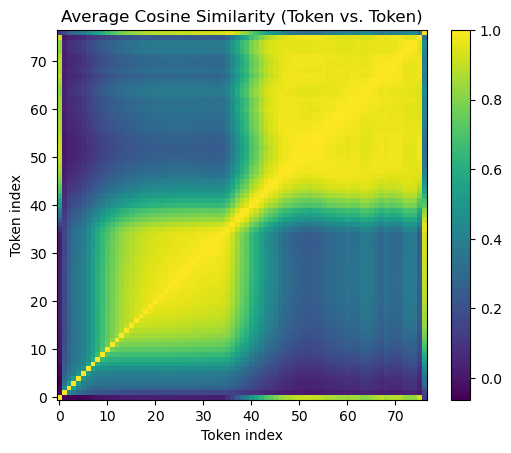

In [10]:
plt.imshow(cos_sim_matrix, origin='lower')
plt.colorbar()
plt.title('Average Cosine Similarity (Token vs. Token)')
plt.xlabel('Token index')
plt.ylabel('Token index')
plt.show()

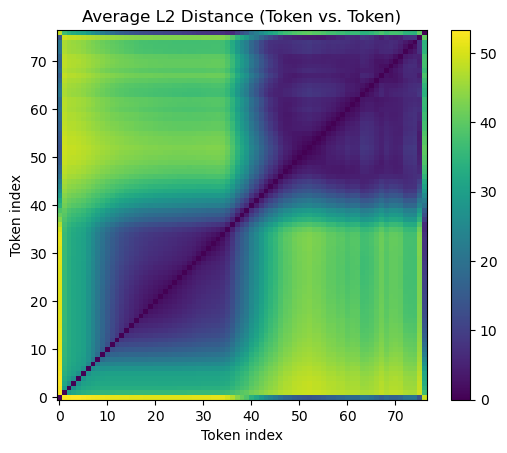

In [11]:
# L2 distance heatmap
plt.imshow(l2_matrix, origin='lower')
plt.colorbar()
plt.title('Average L2 Distance (Token vs. Token)')
plt.xlabel('Token index')
plt.ylabel('Token index')
plt.show()

# Tuned Lens

# Appendix

In [22]:
dataset_lenghts = [len(tokenizer.encode(s)) for s in dataset['txt']]
max(dataset_lenghts)

47

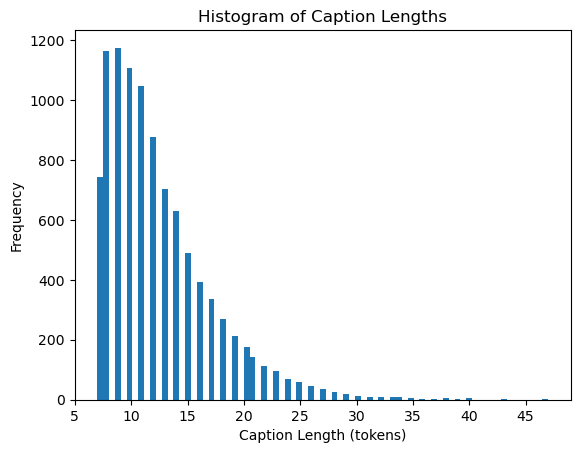

In [23]:
plt.hist(dataset_lenghts, bins=77)
plt.xlabel('Caption Length (tokens)')
plt.ylabel('Frequency')
plt.title('Histogram of Caption Lengths')
plt.show()

In [24]:
caption = dataset['txt'][0]
tokens = tokenizer.encode(caption)
tokens

[49406,
 29072,
 7564,
 953,
 320,
 18664,
 3042,
 1601,
 2054,
 1027,
 1590,
 518,
 874,
 6632,
 539,
 518,
 1063,
 269,
 49407]

In [25]:
tokenizer.convert_ids_to_tokens(tokens)

['<|startoftext|>',
 'cheerleader</w>',
 'celebrates</w>',
 'after</w>',
 'a</w>',
 'touchdown</w>',
 'catch</w>',
 'against</w>',
 'sports</w>',
 'team</w>',
 'during</w>',
 'the</w>',
 'first</w>',
 'quarter</w>',
 'of</w>',
 'the</w>',
 'game</w>',
 '.</w>',
 '<|endoftext|>']

In [26]:
torch.set_printoptions(threshold=700)
for i, row in enumerate(embeddings[0]):
    print(i, row)
torch.set_printoptions(profile='default')

0 tensor([-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675])
1 tensor([-0.7054, -0.6431,  1.4698,  ..., -0.2328,  1.4433,  1.5253])
2 tensor([-0.0691, -2.0457,  1.1803,  ..., -0.3225,  0.3826,  0.5364])
3 tensor([-1.0096, -0.5693,  1.0233,  ...,  0.3792,  0.7902, -0.2150])
4 tensor([-0.2939, -1.1924,  1.3330,  ..., -0.0144, -0.1725,  0.8676])
5 tensor([-0.2824, -0.7433,  1.8958,  ..., -0.3629,  0.0809, -0.8304])
6 tensor([ 0.1000, -1.0624,  1.3841,  ..., -1.0866, -0.4740, -0.5819])
7 tensor([ 0.4653,  0.0349,  1.9089,  ..., -0.3492, -0.1034, -0.1424])
8 tensor([ 0.0464, -1.5397,  1.2917,  ..., -1.5274, -0.0328, -0.3574])
9 tensor([ 0.4038, -0.8301,  1.2747,  ..., -0.5870, -0.0613,  0.3023])
10 tensor([0.0737, 0.4506, 1.2574,  ..., 0.3662, 0.1933, 0.7774])
11 tensor([ 0.3291, -0.0721,  1.6198,  ...,  0.6006,  0.0651,  0.2659])
12 tensor([-1.0831, -0.3760,  2.0515,  ...,  0.8222,  0.2066, -0.7384])
13 tensor([ 1.0165, -2.2182,  1.6131,  ...,  0.1790,  0.1408,  0.2862])
14 tenso